# XAS pump probe signal

This log is part of the experiment 20139026 at beamline DiProi at Fermi/Trieste (Oct.2017)

Here we varry the pump-probe delay at 290 eV for CO/Ru(0001)

### Import

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import h5py
from os import walk

### Define useful functions

In [2]:
def line(x,a,b):
    return a*x+b

def gaussian(x,a,b,c,d):
    return np.abs(a)*np.exp(-4*np.log(2)*(x-b)**2./(c**2))+d

def gaussian0(x,a,b,c):
    return np.abs(a)*np.exp(-4*np.log(2)*(x-b)**2./(c**2))

def fit(function,x,y,p0=None,sigma=None,bounds=None):
    '''
    fits a function and return the fit resulting parameters and curve
    '''
    popt,pcov = curve_fit(function,x,y,p0=p0,sigma=sigma)
    x = np.arange(0,3e3,1e-2)
    curve = function(x,*popt)
    perr = np.sqrt(np.diag(pcov))
    return popt,x,curve,perr

def discover_files(path):
    # looks in the given directory and returns the filenames,
    for (dirpath, dirnames, filenames) in walk(path):
        break
    return filenames

def get_FEL_Spectrum(h5file):
    hor_spectrum   = h5file['photon_diagnostics/Spectrometer/hor_spectrum']
    WavelenghtSpan = h5file['photon_diagnostics/Spectrometer/WavelengthSpan'].value
    Pixel2micron   = h5file['photon_diagnostics/Spectrometer/Pixel2micron'].value
    Wavelenght     = h5file['/photon_diagnostics/Spectrometer/Wavelength'].value
    
    ind = np.arange(0,1000)-500
    x = Wavelenght + ind*Pixel2micron*WavelenghtSpan/1000
    h = 4.135667662*10**(-18)#ev s
    c = 299792458 #m/s
    Energy = h*c/x*1e12
    
    return hor_spectrum,Energy

### Files and folders 

In [3]:
dataset = 11
file_path = '../../../01_data/04_XAS_pp/XAS0%d/'%dataset
print file_path
file_names = discover_files(file_path)
print file_names

../../../01_data/04_XAS_pp/XAS011/
['E307p88eV_Hor_351360546.h5', 'E307p88eV_Hor_351361361.h5', 'E307p88eV_Hor_351362055.h5', 'E307p88eV_Hor_351362768.h5', 'E307p88eV_Hor_351363466.h5', 'E307p88eV_Hor_351364184.h5', 'E307p88eV_Hor_351364898.h5', 'E307p88eV_Hor_351365613.h5', 'E307p88eV_Hor_351366301.h5', 'E307p88eV_Hor_351367024.h5', 'E307p88eV_Hor_351367771.h5', 'E307p88eV_Hor_351368465.h5', 'E307p88eV_Hor_351369182.h5', 'E307p88eV_Hor_351369897.h5', 'E307p88eV_Hor_351370621.h5', 'E307p88eV_Hor_351371337.h5', 'E307p88eV_Hor_351372087.h5', 'E307p88eV_Hor_351372773.h5', 'E307p88eV_Hor_351373468.h5', 'E307p88eV_Hor_351374184.h5', 'E307p88eV_Hor_351374878.h5', 'E307p88eV_Hor_351375624.h5', 'E307p88eV_Hor_351376308.h5', 'E307p88eV_Hor_351377034.h5', 'E307p88eV_Hor_351377750.h5', 'E307p88eV_Hor_351378465.h5', 'E307p88eV_Hor_351379191.h5', 'E307p88eV_Hor_351379906.h5', 'E307p88eV_Hor_351380622.h5', 'E307p88eV_Hor_351381307.h5', 'E307p88eV_Hor_351382001.h5', 'E307p88eV_Hor_351382685.h5', 'E30

### Calculating XAS Pump probe signal

In [5]:
n_bins   = 1000 
thr = 2e5      # threshold filter for i0
x1,x2 = 240,290#80,12 # range for calculating offset

n_delays  = len(file_names)
Spectrum  = np.zeros(n_bins)
pp_delay  = np.zeros(n_delays)
pp_signal = np.zeros(n_delays) 
pp_error  = np.zeros(n_delays) 
i0_avg    = np.zeros(n_delays) 
XAS_avg   = np.zeros(n_delays) 
i0_all    = []
XAS_all   = []

for i in range(n_delays):
    # load files
    h5file = h5py.File(file_path+file_names[i], 'r')
    pp_delay[i]   = h5file['/Laser/DelayPosVector'].value[0]
    XAS_intensity = h5file['/Laser/BaslerInt2'].value
    #pump_intensity = h5file['/Laser/Energy1'].value
    FEL_intensity,Energy = get_FEL_Spectrum(h5file)
    
    # subtract background in FEL spectrometer
    FEL_intensity = np.array(FEL_intensity,dtype=float)
    n_shots = len(XAS_intensity)
    for j in range(n_shots):
        offset = np.average(FEL_intensity[j,x1:x2])
        FEL_intensity[j,:] -= float(offset)
    FEL_intensity[FEL_intensity<0]=0
    Spectrum += np.average(FEL_intensity,axis=0)
        
    # calculate pump probe signal 
    i0 = np.sum(FEL_intensity,axis=1)
    
    good_shots = np.ones(n_shots)
    good_shots[i0<thr] = 0
    i0_all.extend(i0[good_shots==1])
    XAS_all.extend(XAS_intensity[good_shots==1])
    
    pp = XAS_intensity/i0#/pump_intensity
    pp_signal[i] = np.average(pp[good_shots==1])
    pp_error[i]  = np.std(pp[good_shots==1])/np.sqrt(len(pp[good_shots==1]))
    i0_avg[i]    = np.average(i0[good_shots==1])
    XAS_avg[i]   = np.average(XAS_intensity[good_shots==1])

Spectrum/=float(n_delays)    

/Users/fivos/pyvos/lib/python2.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in divide


### Plotting the FEL spectrum

The spectrum in the range [x1:x2] is used for the offset subtraction in the i0

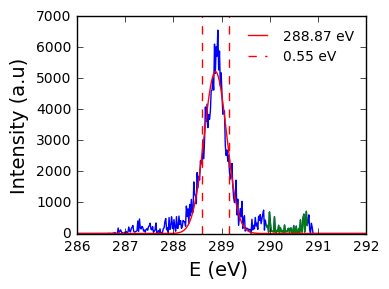

In [15]:
plt.figure(figsize=[4,3])

plt.plot(Energy,Spectrum,'-')
plt.plot(Energy[x1:x2],Spectrum[x1:x2],'-')

x,y = Energy,Spectrum
popt,xc,curve,perr = fit(gaussian0,x[y>0],y[y>0],p0=[max(y),x[y==max(y)][0],0.1])
plt.plot(xc,curve,lw=1,label='%.2f eV'%popt[1])
plt.axvline(x=popt[1]-popt[2]/2,ls='--',label='%.2f eV'%popt[2],c='red')
plt.axvline(x=popt[1]+popt[2]/2,ls='--',c='red')
plt.xlabel(r'E (eV) ',size=14)
plt.ylabel('Intensity (a.u)',size=14)
plt.xlim(286,292)
plt.legend(frameon=False,loc='upper right', prop={'size': 10})
plt.tight_layout()
plt.show()

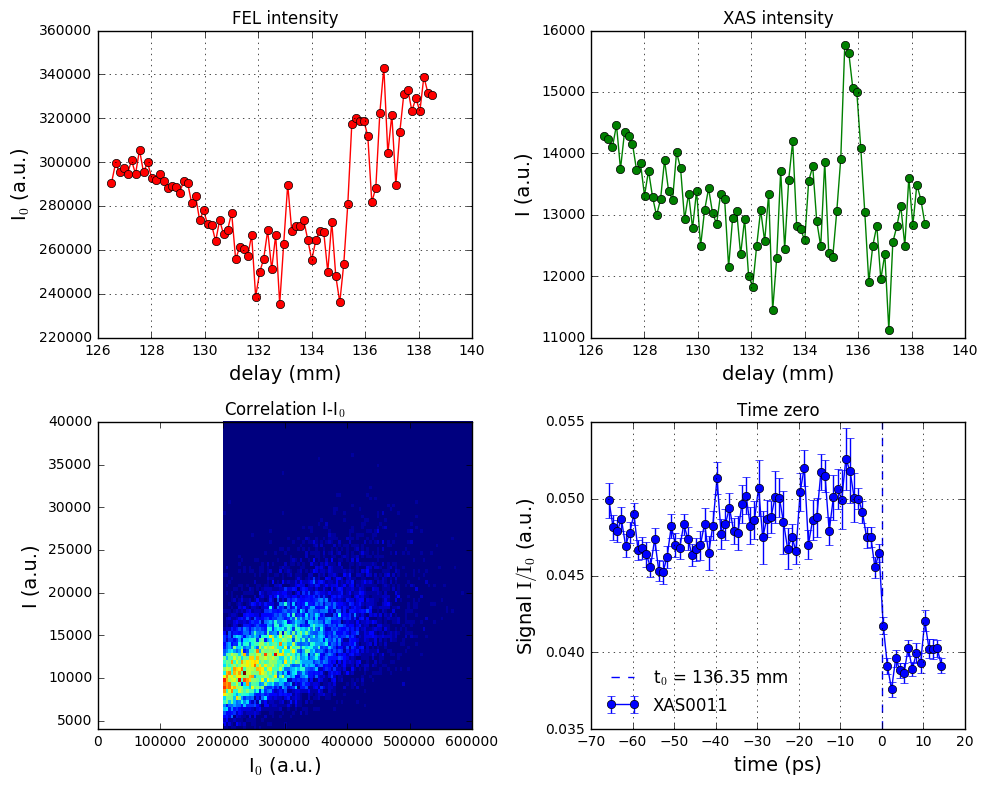

In [47]:
plt.figure(figsize=[10,8])

plt.subplot(2,2,1)
plt.plot(pp_delay,i0_avg,'o-',c='red')
plt.ylabel('I$_0$ (a.u.)',size=14)
plt.xlabel('delay (mm)',size=14)
plt.grid()
plt.title('FEL intensity')

plt.subplot(2,2,2)
plt.plot(pp_delay,XAS_avg,'o-',c='green')
plt.ylabel('I (a.u.)',size=14)
plt.xlabel('delay (mm)',size=14)
plt.grid()
plt.title('XAS intensity')

plt.subplot(2,2,3)
x,y =i0_all,XAS_all
#plt.plot(x,y,'o',ms=2,alpha=0.1,markeredgecolor='none')
plt.hist2d(x,y,bins=100)

plt.xlabel('I$_0$ (a.u.)',size=14)
plt.ylabel('I (a.u.)',size=14)
plt.title('Correlation I-I$_0$')

plt.xlim(0,6e5)
plt.ylim(4e3,4e4)

plt.subplot(2,2,4)
t0 = 136.35
c = 299792458 #m/s

plt.errorbar((pp_delay-t0)*2*1e-3/c*1e12,pp_signal,yerr=pp_error,fmt='o-',label='XAS00%d'%dataset)
plt.title('Time zero')
plt.ylabel(r'Signal $\rm I/I_0$ (a.u.)',size=14)
plt.xlabel('time (ps)',size=14)
plt.axvline(x=0,ls='--',label=r't$_0$ = %.2f mm'%(t0))
plt.grid()
plt.tight_layout()
plt.legend(frameon=False,loc='lower left', prop={'size': 12})

#plt.savefig('/Users/fivos/Desktop/fig_pp0%d.png'%dataset,dpi=300)
#np.save('/Users/fivos/Desktop/pp_XAS00%d'%dataset,np.array([pp_delay,pp_signal,pp_error]))

plt.show()